# Slot latency analysis

In [13]:
import sys

sys.executable

import pandas as pd
import matplotlib.pyplot as plt

# Load dataframe
csv_path = "out.csv"
df = pd.read_csv(csv_path)


The document is to analyze the slot latency. As an input it requires output file of the `rate-latency-tool` (`out.csv`).
This tool sends Memo transactions at specified time interval during specified time range.
Each transactions contains the following information:
* `signature` -- tx signature
* `transaction_id` -- id of generated transactions from 0 to `duration*1000/send_interval`
* `sent_timestamp` -- timestamp recorded when transaction has been generated
* `sent_slot` -- estimated by client slot when transaction has been sent
* `received_slot` -- when tx has been added to the block
* `sent_timestamp`, `received_timestamp`, `received_subscr_timestamp` -- timestamp when we sent transaction, when we received notification about this tx, when yellostone-grpc server side received this tx
* `tx_status` -- a string containing the statuses of the transaction sent to each of the leader from fanout set in the format `(<Status>\(IP:PORT\)|)*`.

Each transaction is generated right before sending and if send has failed, it is dropped.
The default send `Fanout` is 1.


Lets investigate the slot latency overall:

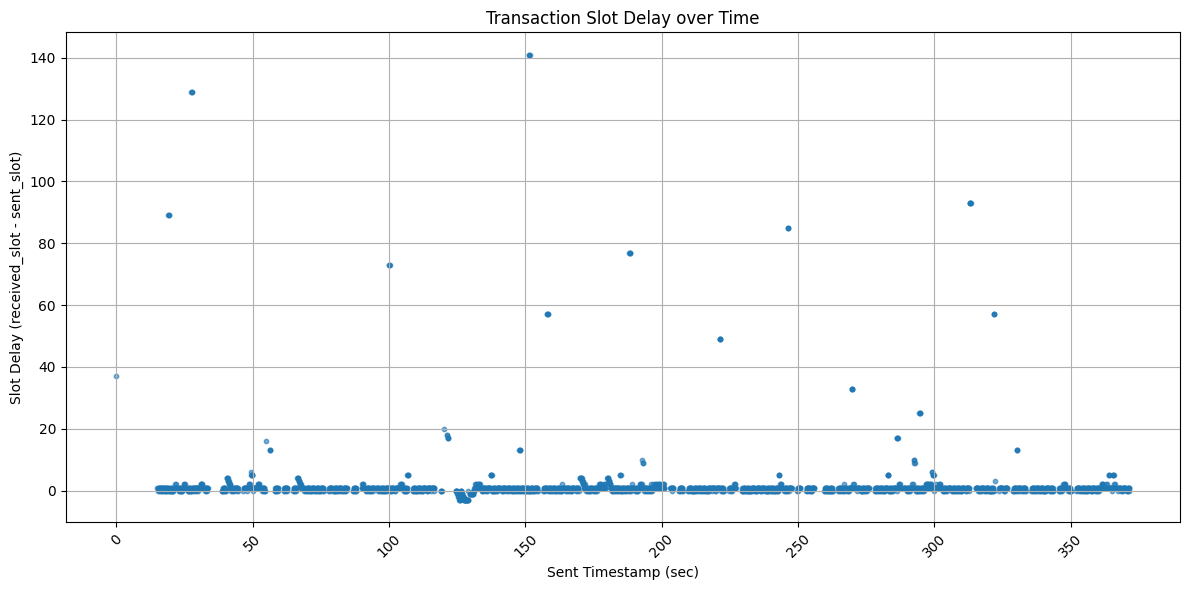

In [14]:

def plot_slot_delays(df: pd.DataFrame):
    # Create the scatter plot
    plt.figure(figsize=(12, 6))
    plt.scatter(df['time_since_start'], df['slot_diff'], s=10, alpha=0.6)

    # Labeling
    plt.xlabel('Sent Timestamp (sec)')
    plt.ylabel('Slot Delay (received_slot - sent_slot)')
    plt.title('Transaction Slot Delay over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()


# Calculate the slot difference
df['slot_diff'] = df['received_slot'] - df['sent_slot']

# Convert sent_timestamp to relative time in seconds for plotting
t0 = df['sent_timestamp'].min()
df['time_since_start'] = (df['sent_timestamp'] - t0) / 1000.0  # in seconds
plot_slot_delays(df)


(np.float64(2.263803680981595),
 np.float64(10.613058353793102),
 np.float64(1.0))

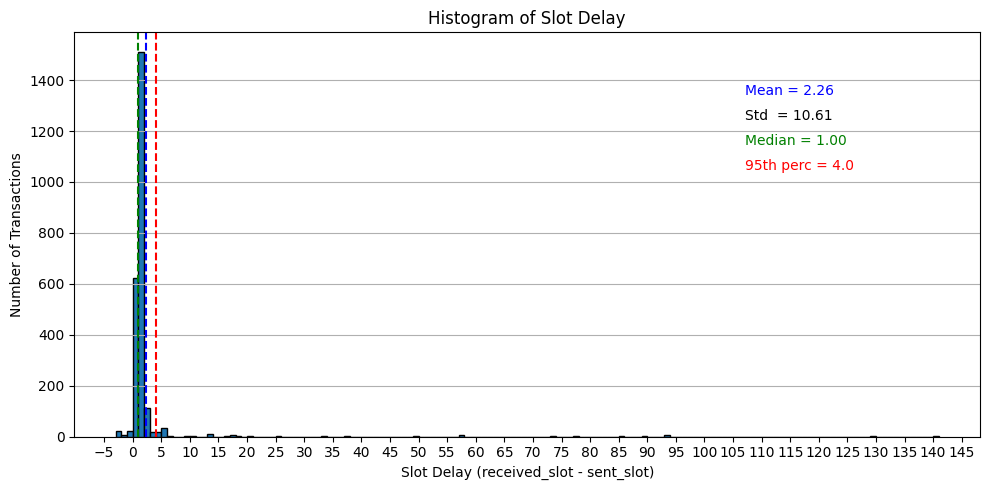

In [15]:
def plot_slot_delay_histogram(df: pd.DataFrame ):
    df['slot_diff'] = df['received_slot'] - df['sent_slot']

    min_diff = int(df['slot_diff'].min())
    max_diff = int(df['slot_diff'].max())

    plt.figure(figsize=(10, 5))
    plt.hist(df['slot_diff'], bins=range(min_diff, max_diff + 1), edgecolor='black')

    plt.xlabel('Slot Delay (received_slot - sent_slot)')
    plt.ylabel('Number of Transactions')
    plt.title('Histogram of Slot Delay')
    plt.grid(axis='y')

    # Set step size
    step = 5  # Adjust as needed

    # Ensure 0 is in the ticks
    tick_start = (min_diff // step) * step
    tick_end = ((max_diff + step - 1) // step) * step
    ticks = list(range(tick_start, tick_end + 1, step))

    if 0 not in ticks:
        ticks.append(0)
        ticks.sort()

    plt.xticks(ticks)

    # Add vertical lines
    mean_val = df['slot_diff'].mean()
    std_val = df['slot_diff'].std()
    median_val = df['slot_diff'].median()
    quantile = 0.95
    threshold = df['slot_diff'].quantile(quantile)
    plt.axvline(threshold, color='red', linestyle='dashed', linewidth=1.5,
                label=f'95th percentile ({threshold:.1f})')
    plt.axvline(mean_val, color='blue', linestyle='dashed', linewidth=1.5,
                label=f'Mean ({mean_val:.2f})')
    plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1.5,
                label=f'Median ({median_val:.2f})')

    # Coordinates for annotation box
    x_text, y_text = 0.75, 0.75
    plt.gcf().text(x_text, y_text + 0.05, f'Mean = {mean_val:.2f}', fontsize=10, color='blue')
    plt.gcf().text(x_text, y_text, f'Std  = {std_val:.2f}', fontsize=10, color='black')  # std has no line
    plt.gcf().text(x_text, y_text - 0.05, f'Median = {median_val:.2f}', fontsize=10, color='green')
    plt.gcf().text(x_text, y_text - 0.10, f'95th perc = {threshold:.1f}', fontsize=10, color='red')


    plt.tight_layout()

plot_slot_delay_histogram(df)

df['slot_diff'].mean(), df['slot_diff'].std(), df['slot_diff'].median()

We spot quite some outliers which disturb the visual representation.
So lets filter outliers and plot slot latency again 

4.0


/tmp/ipykernel_1032019/294956353.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time_bin'] = (filtered_df['time_since_start'] // bin_size) * bin_size


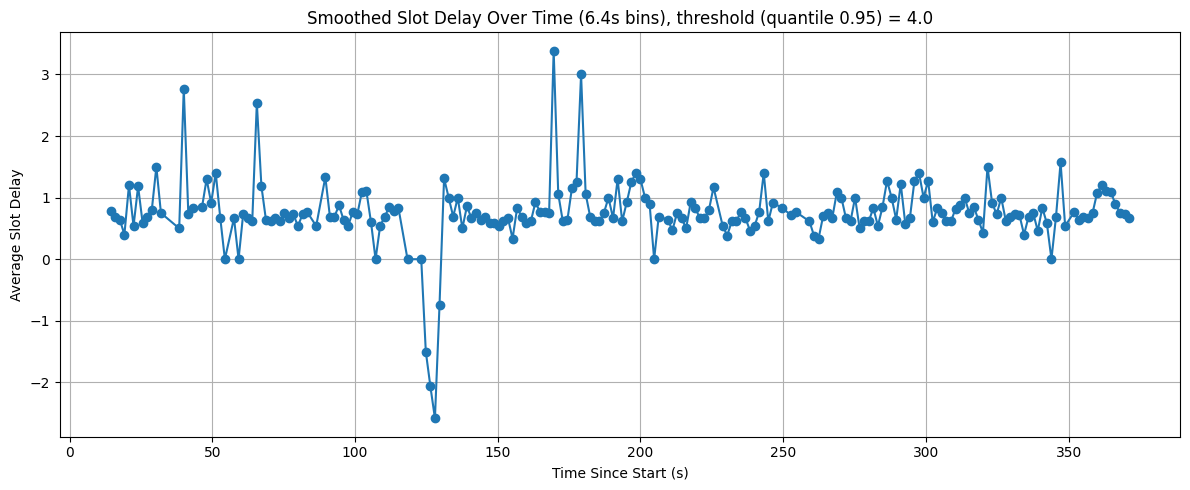

In [16]:
# Remove outliers, plot using average over the `bin_size`.
quantile = 0.95
threshold = df['slot_diff'].quantile(quantile)
print(threshold)
filtered_df = df[df['slot_diff'] <= threshold]

bin_size = 0.4*4
filtered_df['time_bin'] = (filtered_df['time_since_start'] // bin_size) * bin_size

grouped = filtered_df.groupby('time_bin')['slot_diff'].mean().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(grouped['time_bin'], grouped['slot_diff'], marker='o', linestyle='-')
plt.xlabel('Time Since Start (s)')
plt.ylabel('Average Slot Delay')
plt.title(f'Smoothed Slot Delay Over Time ({4 * bin_size:.1f}s bins), threshold (quantile {quantile:.2f}) = {threshold:.1f}')
plt.grid(True)
plt.tight_layout()


Lets also check the scatter plot for the `sent_timestamp` and `received_timestamp`. This `received_timestamp` includes the latency introduces by using intermediate service to get this information. 

Time drift between client and yellostone host for the 1st transaction:  40.714  sec


/tmp/ipykernel_1032019/3229722612.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


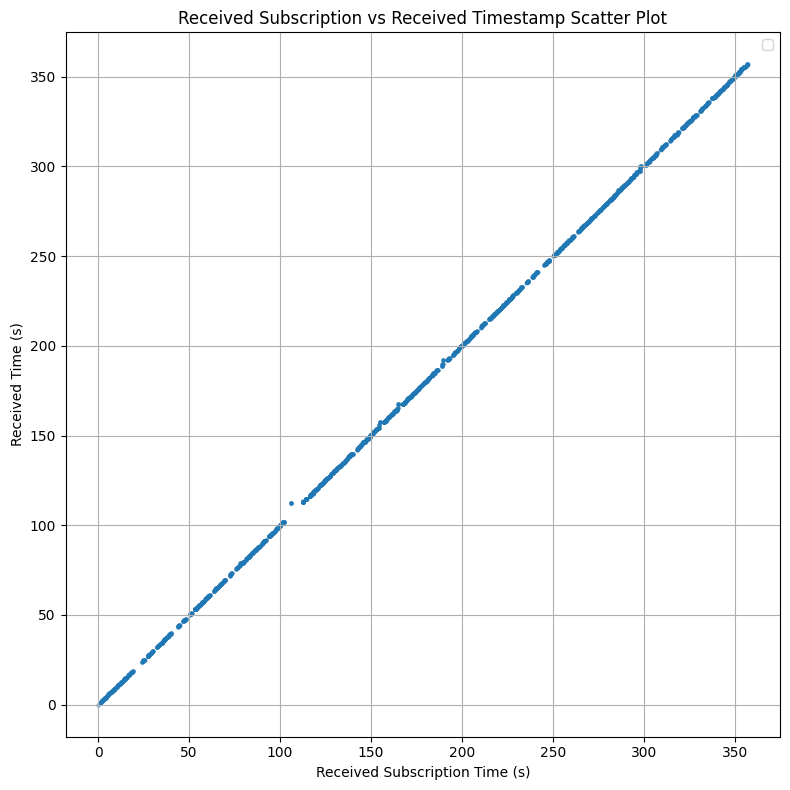

In [17]:
df = df.sort_values('sent_timestamp')

first_received = df['received_timestamp'].min()
first_subscr_received = df['received_subscr_timestamp'].min()
print("Time drift between client and yellostone host for the 1st transaction: ", (first_received - first_subscr_received)/1000.0, " sec")

df['recv_subscr_sec'] = (df['received_subscr_timestamp'] - first_subscr_received) / 1000.0
df['recv_sec'] = (df['received_timestamp'] - first_received) / 1000.0

plt.figure(figsize=(8, 8))
plt.scatter(df['recv_subscr_sec'], df['recv_sec'], s=5, alpha=0.5)

plt.xlabel('Received Subscription Time (s)')
plt.ylabel('Received Time (s)')
plt.title('Received Subscription vs Received Timestamp Scatter Plot')
plt.legend()
plt.grid(True)
plt.tight_layout()

Time drift between client and yellostone host for the 1st transaction:  15.439  sec


/tmp/ipykernel_1032019/1442936812.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


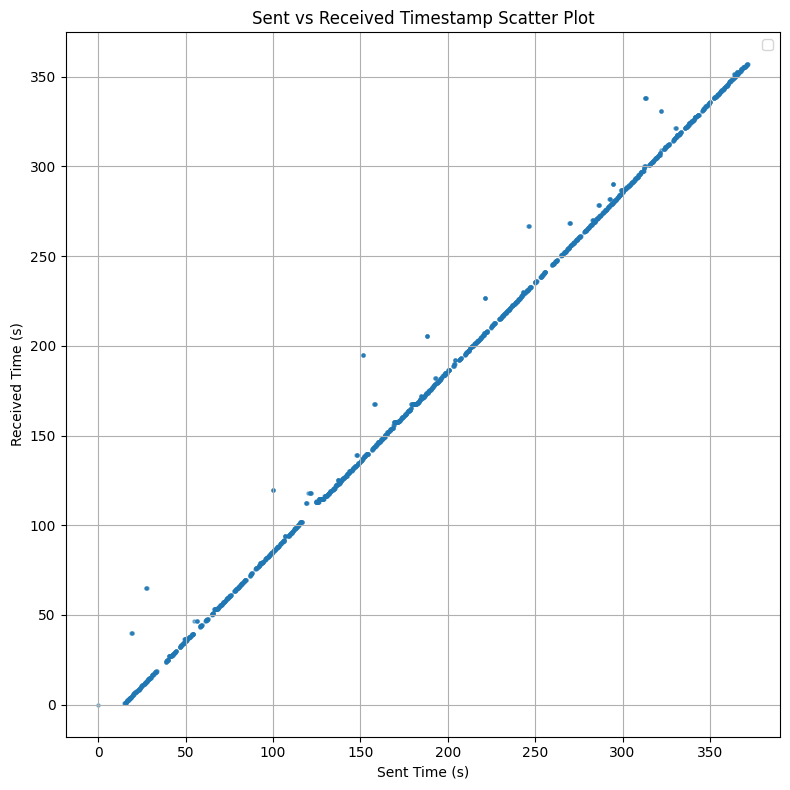

In [18]:
df = df.sort_values('sent_timestamp')
first_sent = df['sent_timestamp'].iloc[0]
last_sent = df['sent_timestamp'].iloc[-1]
first_received = df['received_timestamp'].min()
print("Time drift between client and yellostone host for the 1st transaction: ", (first_received - first_sent)/1000.0, " sec")

df['sent_sec'] = (df['sent_timestamp'] - first_sent) / 1000.0
df['recv_sec'] = (df['received_timestamp'] - first_received) / 1000.0

plt.figure(figsize=(8, 8))
plt.scatter(df['sent_sec'], df['recv_sec'], s=5, alpha=0.5)

plt.xlabel('Sent Time (s)')
plt.ylabel('Received Time (s)')
plt.title('Sent vs Received Timestamp Scatter Plot')
plt.legend()
plt.grid(True)
plt.tight_layout()

## Analysis of missing transactions

When transaction is sent to the worker, this operation can return one of the following results:

1. Ok, it has been sent. This is different from being added to the block.
2. ShutdownError 
3. ReceiverDropped
4. FullChannel 
5. Other errors

Since we can send to more than 1 worker, we potentially have a list of the results with IP:PORT in the field `tx_status`.


Sent+Received    2445
Sent+Lost         654
FullChannel       476
Name: count, dtype: int64


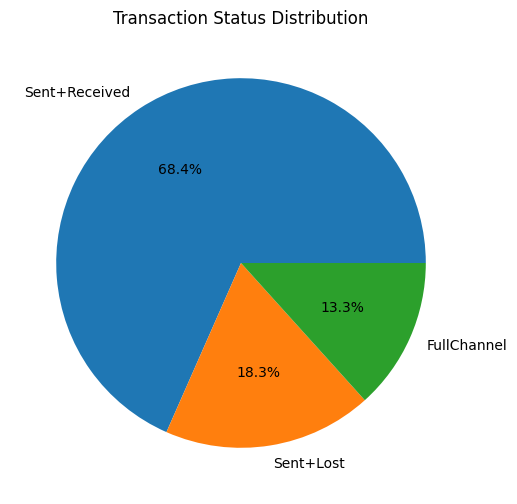

In [19]:
import re

def parse_status(row):
    status_str = row["tx_status"]
    if pd.isna(status_str):  # skip missing values
        return None

    parts = status_str.split('|')
    statuses = [re.match(r"^([^(]+)", p).group(1) for p in parts if re.match(r"^([^(]+)", p)]

    if not statuses:
        return None

    # Rule: if there's any "Sent"
    if "Sent" in statuses:
        if pd.notna(row["received_slot"]):
            return "Sent+Received"
        else:
            return "Sent+Lost"

    # Otherwise: just return the first status
    return statuses[0]

# Apply parsing to each row, flatten into a single list
all_statuses = []
for _, row in df.iterrows():
    all_statuses.append(parse_status(row))

# Count occurrences
status_counts = pd.Series(all_statuses).value_counts()

print(status_counts)

# Plot as pie chart
status_counts.plot.pie(autopct='%1.1f%%', figsize=(6, 6))
plt.ylabel("")  # remove y-label
plt.title("Transaction Status Distribution")
plt.show()
